# 手机数据预测--自动分析特征训练

## 1. 分类问题

- Feature importances with a forest of trees:https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

从论文【City-Scale Localization with Telco Big Data】中获知：MR数据中的id等数据中编码了路网的结构信息。但人为无法发现其内部信息，所以我们借助网络自动提取一些特征作为训练集。

In [1]:
import pandas as pd
import numpy as np

In [3]:
# 读取数据
auto_data = pd.read_csv("../data/2G_data.csv", encoding = 'gbk')

#匹配工参 -- 用来计算相对数据
auto_data_gongcan = pd.read_csv("../data/2G_gongcan.csv", encoding = 'gbk')

# 将列名全部小写
auto_data.rename(str.lower, axis='columns', inplace=True)
auto_data_gongcan.rename(str.lower, axis='columns', inplace=True)

print("数据集：")
print(auto_data.head(1))
print("工参：")
print(auto_data_gongcan.head(1))

数据集：
         mrtime   longitude   latitude  rncid_1  cellid_1  signallevel_1  \
0  1.510000e+12  121.213563  31.291798     6188     26051              4   

   rssi_1  rncid_2  cellid_2  signallevel_2  ...  rncid_6  cellid_6  \
0     -59     6188     27394              3  ...   6188.0   27393.0   

   signallevel_6  rssi_6  rncid_7  cellid_7  signallevel_7  rssi_7  linknum  \
0            3.0   -95.0   6182.0   44754.0            3.0   -95.0        7   

   id_c5ombine  
0        32239  

[1 rows x 33 columns]
工参：
   rncid  cellid   longitude   latitude type
0   6182   13666  121.191709  31.287846  NaN


In [4]:
# 栅格划分 坐标转换
lonStep_1m = 0.0000105
latStep_1m = 0.0000090201

# 划分栅格
class RoadGrid:
    def __init__(self, label, grid_size):
        length = grid_size * latStep_1m
        width = grid_size * lonStep_1m
        self.length = length
        self.width = width
        def orginal_plot(label):
            tr = np.max(label,axis=0)
            tr[0]+=25*lonStep_1m
            tr[1]+=25*latStep_1m
            # plot(label[:,0], label[:,1], 'b,')
            bl = np.min(label,axis=0)
            bl[0]-=25*lonStep_1m
            bl[1]-=25*latStep_1m

            # width = (tr[1]-bl[1])/100
            # wnum =int(np.ceil((tr[1]-bl[1])/length))
            # for j in range(wnum):
                # hlines(y = bl[1]+length*j, xmin = bl[0], xmax = tr[0], color = 'red')

            # lnum = int(np.ceil((tr[0]-bl[0])/width))
            # for j in range(lnum):
                # vlines(x = bl[0]+width*j, ymin = bl[1], ymax = tr[1], color = 'red')
            return bl[0], tr[0], bl[1], tr[1]

        xl,xr,yb,yt = orginal_plot(label)
        self.xl = xl
        self.xr = xr
        self.yb = yb
        self.yt = yt
        gridSet = set()
        grid_dict = {}
        self.grid_dict = {}
        for pos in label:
            lon = pos[0]
            lat = pos[1]

            m = int((lon-xl)/width)
            n = int((lat-yb)/length)
            if (m,n) not in grid_dict:
                grid_dict[(m,n)] = []
            grid_dict[(m,n)].append((lon, lat))
            gridSet.add((m,n))
        # print len(gridSet)
        gridlist = list(gridSet)

            
            
        grid_center = [tuple(np.mean(np.array(grid_dict[grid]),axis=0)) for grid in gridlist]


        # for gs in gridSet:
            # xlon = xl+gs[0]*width
            # ylat = yb+gs[1]*length
            # bar(xlon,length,width,ylat,color='#7ED321')
        self.gridlist = gridlist

        self.grids = [(xl+i[0]*width,yb + i[1]*length) for i in grid_dict.keys()] # 左下角的点
        self.grid_center = grid_center
        self.n_grid = len(self.grid_center)
        self.grid_dict = grid_dict

    def transform(self, label, sparse=True):
        def one_hot(idx, n):
            a = [0] * n
            a[idx] = 1
            return a
        grid_pos = [self.gridlist.index((int((i[0]-self.xl)/self.width),int((i[1]-self.yb)/self.length))) for i in label]
        if sparse:
            grid_pos = np.array([one_hot(x, len(self.gridlist)) for x in grid_pos], dtype=np.int32)
        return grid_pos
    
def rad(d):
    return d * math.pi / 180.0

# 地理坐标系：为球面坐标。 参考平面地是椭球面，坐标单位：经纬度；
# 投影坐标系：为平面坐标。参考平面地是水平面，坐标单位：米、千米等；
# 地理坐标转换到投影坐标的过程可理解为投影。（投影：将不规则的地球曲面转换为平面）

# 目前国内主要有三种地理坐标系
# 1、WGS84坐标系：即地球坐标系（World Geodetic System），国际上通用的坐标系。
# 设备包含的GPS芯片或者北斗芯片获取的经纬度一般都是为WGS84地理坐标系，目前谷歌地图采用的是WGS84坐标系（中国范围除外）。
# 2、GCJ02坐标系：即火星坐标系，国测局坐标系。是由中国国家测绘局制定。由WGS84坐标系经加密后的坐标系。谷歌中国和搜搜中国采用。
# 3、BD09坐标系：百度坐标系，GCJ02坐标系经加密后的坐标系。

# 投影：墨卡托投影、高斯-克吕格 (Gauss-Krüger) 投影
# 感兴趣的同学可以在https://desktop.arcgis.com/zh-cn/arcmap/10.3/guide-books/map-projections/list-of-supported-map-projections.htm深入了解

# gps两点间距离（单位为米）
def distance(true_pt, pred_pt):
    lat1 = float(true_pt[1])
    lng1 = float(true_pt[0])
    lat2 = float(pred_pt[1])
    lng2 = float(pred_pt[0])
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2),2) +
    math.cos(radLat1)*math.cos(radLat2)*math.pow(math.sin(b/2),2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s

In [5]:
# 划分栅格

grid_size = 20 # 栅格大小：越小，精度越高，错误率也越高。

# 根据longitude和latitude将定位数据分配在不同的栅格中
grider = RoadGrid(auto_data[['longitude', 'latitude']].values, grid_size)
auto_data['grid_id'] = grider.transform(auto_data[['longitude', 'latitude']].values, False)

# 查看数据
print(auto_data.head(1))

         mrtime   longitude   latitude  rncid_1  cellid_1  signallevel_1  \
0  1.510000e+12  121.213563  31.291798     6188     26051              4   

   rssi_1  rncid_2  cellid_2  signallevel_2  ...  cellid_6  signallevel_6  \
0     -59     6188     27394              3  ...   27393.0            3.0   

   rssi_6  rncid_7  cellid_7  signallevel_7  rssi_7  linknum  id_c5ombine  \
0   -95.0   6182.0   44754.0            3.0   -95.0        7        32239   

   grid_id  
0      194  

[1 rows x 34 columns]


In [9]:
# 回归重要性评估
from sklearn.feature_selection import mutual_info_regression


auto_data = auto_data.fillna(-999)
features = auto_data.iloc[:, 3:33].dtypes == 'int64'
scores = mutual_info_regression(auto_data.iloc[:, 3:33],
                                auto_data['grid_id'],
                               discrete_features=features)
scores = pd.Series(scores, name='Feature Importance', index=auto_data.iloc[:, 3:33].columns)
scores = scores.sort_values(ascending=False)
print(" Feature", "        Weight")
print(scores)

 Feature         Weight
id_c5ombine      1.725102
cellid_1         1.725102
cellid_3         1.640966
cellid_2         1.614974
cellid_4         1.588000
cellid_5         1.418681
cellid_6         1.151112
rssi_3           0.849457
rssi_2           0.821008
rssi_4           0.796912
rssi_5           0.781947
rssi_6           0.709976
cellid_7         0.627192
rncid_3          0.592715
rncid_4          0.553449
rncid_2          0.547076
rncid_5          0.529496
rssi_1           0.517796
rncid_1          0.474313
rssi_7           0.470333
rncid_6          0.440148
linknum          0.332809
signallevel_3    0.300838
rncid_7          0.296060
signallevel_6    0.291891
signallevel_2    0.275897
signallevel_7    0.246317
signallevel_5    0.239754
signallevel_4    0.229584
signallevel_1    0.039738
Name: Feature Importance, dtype: float64


对比人工采集特征，我们发现id中隐藏着更重要的信息，可能包含了基站的位置信息，从而对分类结果的影响更大。

In [10]:
from sklearn.model_selection import train_test_split  # 数据集划分

auto_data = auto_data.fillna(-999)
# 划分训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(
                auto_data,
                auto_data[['longitude','latitude','grid_id']],
                test_size=0.2,
                random_state=200)

In [11]:
# 训练特征: 可以动态修改特征进行训练  这里排除了signallevel特征
feature_cloumns_name = [
   'id_c5ombine', 'cellid_1', 'cellid_2', 'cellid_3', 'cellid_4', 'cellid_5',
    'cellid_6', 'rssi_3', 'rssi_2', 'rssi_4','rssi_5','rssi_6','cellid_7',
    'rncid_3', 'rncid_4', 'rncid_2', 'rssi_1', 'rncid_5', 'rncid_1', 'rssi_7',
    'rncid_6', 'linknum'
]

In [12]:
# 分类模型
from sklearn.tree import DecisionTreeClassifier       # 决策树
from sklearn.neighbors import KNeighborsClassifier    # K最近邻
from sklearn.ensemble import RandomForestClassifier   # 随机森林
from sklearn.naive_bayes import GaussianNB            # 高斯贝叶斯分类器
from sklearn.model_selection import train_test_split  # 数据集划分

# 分类器
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "K Neighbors" : KNeighborsClassifier(n_neighbors=2),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Gaussian NB": GaussianNB()
}

In [14]:
import math

median = []
mean = []
nine = []
# 10-fold cross validation  直接在训练过程中进行交叉验证
for name, clf in classifiers.items():
    med, mea, nin = [], [], []
    print(name, ": ")
    for i in range(10):
        regr = clf.fit(X_train[feature_cloumns_name], y_train['grid_id'])
        pred = regr.predict(X_test[feature_cloumns_name])
        pred_loc = np.array([grider.grid_center[idx] for idx in pred])
        err = [distance(p,t) for p, t in zip(pred_loc, y_test[['longitude','latitude']].values)]
        err = sorted(err)
        med.append(np.median(err))
        mea.append(np.mean(err))
        nin.append(err[int(len(err)*0.9)])
        print (np.median(err), np.mean(err), err[int(len(err)*0.9)])
    # 中位数误差   平均误差    随机获取一个误差
    median.append(np.mean(med))
    mean.append(np.mean(mea))
    nine.append(np.mean(nin))
    print (np.mean(med), np.mean(mea), np.mean(nin))

Random Forest : 
9.1 25.666891322662178 31.1
9.1 24.75846672283067 32.5
9.2 25.798230834035387 31.1
9.3 25.371356360572875 32.3
9.1 26.17127211457456 32.2
9.1 24.96284751474305 32.2
9.1 25.49005897219882 32.8
9.1 23.804043807919122 30.7
9.2 25.018955349620892 32.3
9.3 28.408761583824774 32.8
9.16 25.54508845829823 32.0
K Neighbors : 
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945243 293.6
13.2 89.72737994945241 293.6
Decision Tree : 
510.0 488.66015164279696 987.4
510.0 488.6722830665543 987.4
510.0 488.6722830665543 987.4
510.0 488.66015164279696 987.4
510.0 488.66015164279696 987.4
510.0 488.6722830665543 987.4
510.0 488.66015164279696 987.4
510.0 488.66015164279696 987.4
510.0 488.66015164279696 987.4
510.0 488.66015164279696 987.4
510.0 488.66379106992

In [16]:
print(median)
print(mean)
print(nine)

[9.16, 13.2, 510.0, 49.60000000000001]
[25.54508845829823, 89.72737994945241, 488.6637910699242, 202.97590564448188]
[32.0, 293.6, 987.4, 664.6000000000001]


## 2. 相对位置回归预测

In [21]:
import pandas as pd
import numpy as np

In [82]:
# 读取数据
hand_data = pd.read_csv("../data/2G_data.csv", encoding = 'gbk')

#匹配工参 -- 用来计算相对数据
hand_data_gongcan = pd.read_csv("../data/2G_gongcan.csv", encoding = 'gbk')

# 将列名全部小写
hand_data.rename(str.lower, axis='columns', inplace=True)
hand_data_gongcan.rename(str.lower, axis='columns', inplace=True)

# 重命名
hand_data.rename(columns={'rncid_1':'rncid','cellid_1':'cellid'}, inplace=True)
hand_data_gongcan.rename(columns={'longitude':'real_longi','latitude':'real_lati'}, inplace=True)

print("数据集：")
print(hand_data.head(1))
print("工参：")
print(hand_data_gongcan.head(1))

数据集：
         mrtime   longitude   latitude  rncid  cellid  signallevel_1  rssi_1  \
0  1.510000e+12  121.213563  31.291798   6188   26051              4     -59   

   rncid_2  cellid_2  signallevel_2  ...  rncid_6  cellid_6  signallevel_6  \
0     6188     27394              3  ...   6188.0   27393.0            3.0   

   rssi_6  rncid_7  cellid_7  signallevel_7  rssi_7  linknum  id_c5ombine  
0   -95.0   6182.0   44754.0            3.0   -95.0        7        32239  

[1 rows x 33 columns]
工参：
   rncid  cellid  real_longi  real_lati type
0   6182   13666  121.191709  31.287846  NaN


In [83]:
# 合并两个DF
data = hand_data.merge(hand_data_gongcan,how="left",on=["rncid","cellid"])
        
data.reset_index(drop=True)

print(data.head(1))

         mrtime   longitude   latitude  rncid  cellid  signallevel_1  rssi_1  \
0  1.510000e+12  121.213563  31.291798   6188   26051              4     -59   

   rncid_2  cellid_2  signallevel_2  ...  rssi_6  rncid_7  cellid_7  \
0     6188     27394              3  ...   -95.0   6182.0   44754.0   

   signallevel_7  rssi_7  linknum  id_c5ombine  real_longi  real_lati  type  
0            3.0   -95.0        7        32239  121.211928  31.288649   NaN  

[1 rows x 36 columns]


In [84]:
# 计算相对位置
relative_longitude = []   
relative_latitude = []
for index, row in data.iterrows():
    # 手机坐标减去基站坐标
    relative_longitude = row['longitude'] - row['real_longi']
    relative_latitude = row['latitude'] - row['real_lati']

data['relative_longi'] = relative_longitude
data['relative_lati'] = relative_latitude

print(data.head(1))

         mrtime   longitude   latitude  rncid  cellid  signallevel_1  rssi_1  \
0  1.510000e+12  121.213563  31.291798   6188   26051              4     -59   

   rncid_2  cellid_2  signallevel_2  ...  cellid_7  signallevel_7  rssi_7  \
0     6188     27394              3  ...   44754.0            3.0   -95.0   

   linknum  id_c5ombine  real_longi  real_lati  type  relative_longi  \
0        7        32239  121.211928  31.288649   NaN       -0.011482   

   relative_lati  
0       0.026615  

[1 rows x 38 columns]


In [66]:
# 回归重要性评估
from sklearn.feature_selection import mutual_info_regression

data = data.fillna(-999)
features = data.iloc[:, 3:35].dtypes == 'int64'
scores = mutual_info_regression(data.iloc[:, 3:35],
                               data['relative_lati'],
                               discrete_features=features)
scores = pd.Series(scores, name='Feature Importance', index=data.iloc[:, 3:35].columns)
scores = scores.sort_values(ascending=False)
print(scores)

cellid_2         0.023957
real_longi       0.016607
rssi_4           0.015451
rncid_3          0.012102
cellid_4         0.011712
cellid_5         0.011119
rncid_2          0.009413
rncid_6          0.009115
rssi_6           0.008880
cellid_3         0.006656
rssi_2           0.006319
real_lati        0.004566
signallevel_7    0.004395
cellid           0.004027
id_c5ombine      0.004027
signallevel_5    0.003802
signallevel_4    0.002249
signallevel_1    0.001460
rssi_1           0.001287
signallevel_6    0.000545
rssi_5           0.000000
rssi_7           0.000000
linknum          0.000000
signallevel_2    0.000000
cellid_7         0.000000
signallevel_3    0.000000
rssi_3           0.000000
rncid_4          0.000000
rncid_7          0.000000
rncid_5          0.000000
cellid_6         0.000000
rncid            0.000000
Name: Feature Importance, dtype: float64


In [59]:
# 回归重要性评估
from sklearn.feature_selection import mutual_info_regression

data = data.fillna(-999)
features = data.iloc[:, 3:35].dtypes == 'int64'
scores = mutual_info_regression(data.iloc[:, 3:35],
                               data['relative_longi'],
                               discrete_features=features)
scores = pd.Series(scores, name='Feature Importance', index=data.iloc[:, 3:35].columns)
scores = scores.sort_values(ascending=False)
print(scores)

cellid_3         0.018376
rssi_3           0.018241
cellid_4         0.014898
signallevel_7    0.014715
cellid_2         0.013621
cellid_7         0.010438
rssi_7           0.007270
id_c5ombine      0.007249
cellid           0.007249
signallevel_3    0.006764
rncid_2          0.006582
cellid_5         0.005038
rncid_7          0.004691
real_longi       0.003892
rssi_6           0.001982
rssi_5           0.000503
rssi_1           0.000000
signallevel_1    0.000000
signallevel_2    0.000000
rssi_2           0.000000
rncid_3          0.000000
real_lati        0.000000
rssi_4           0.000000
rncid_4          0.000000
signallevel_4    0.000000
rncid_5          0.000000
signallevel_5    0.000000
rncid_6          0.000000
cellid_6         0.000000
signallevel_6    0.000000
linknum          0.000000
rncid            0.000000
Name: Feature Importance, dtype: float64


对比可知，在回归预测问题中，变量的重要程度与分类中截然不同。这可能由于使用相对位置直接进行训练导致失去了经纬度与基站分布之间的空间信息。由此，我们定义下面的特征集：

In [79]:
# 训练特征: 可以动态修改特征进行训练  这里排除了signallevel特征
feature_cloumns_name = [
   'id_c5ombine', 'cellid_4', 'cellid', 'rssi_1', 'rssi_2', 'cellid_2',
    'signallevel_2', 'cellid_7', 'cellid_6', 'signallevel_6','rssi_6','rncid_7','rncid_5',
    'signallevel_7', 'rssi_7', 'rssi_5', 'real_longi', 'rncid_6', 'real_lati', 'signallevel_5',
    'cellid_5', 'rssi_4','signallevel_4', 'rncid_4', 'rssi_3', 'signallevel_3'
]

## 总训练

In [13]:
import math
import pandas as pd
import numpy as np

# 读取数据
hand_data = pd.read_csv("../data/2G_data.csv", encoding = 'gbk')

#匹配工参 -- 用来计算相对数据
hand_data_gongcan = pd.read_csv("../data/2G_gongcan.csv", encoding = 'gbk')

# 将列名全部小写
hand_data.rename(str.lower, axis='columns', inplace=True)
hand_data_gongcan.rename(str.lower, axis='columns', inplace=True)

# 重命名
hand_data.rename(columns={'rncid_1':'rncid','cellid_1':'cellid'}, inplace=True)
hand_data_gongcan.rename(columns={'longitude':'real_longi','latitude':'real_lati'}, inplace=True)


# 合并两个DF
data = hand_data.merge(hand_data_gongcan,how="left",on=["rncid","cellid"])
data.reset_index(drop=True)

# 工参中存在经纬度不存在，需要进行不全
lo_avg = []
la_avg = []
for index, row in hand_data_gongcan.iterrows():
    if row['rncid'] == 6182:
        lo_avg.append(row['real_longi'])
        la_avg.append(row['real_lati'])
# 缺失值的均值
# print(np.mean(lo_avg))
# print(np.mean(la_avg))

# 将主基站数据确实的进行填充
data['real_longi'].fillna(np.mean(lo_avg), inplace=True)
data['real_lati'].fillna(np.mean(la_avg), inplace=True)


# 计算相对位置
relative_longitude = []   
relative_latitude = []
for index, row in data.iterrows():
    # 手机坐标减去基站坐标
    relative_longitude = row['longitude'] - row['real_longi']
    relative_latitude = row['latitude'] - row['real_lati']

data['relative_longi'] = relative_longitude
data['relative_lati'] = relative_latitude


# 计算误差
def rad(d):
    return d * math.pi / 180.0

# 地理坐标系：为球面坐标。 参考平面地是椭球面，坐标单位：经纬度；
# 投影坐标系：为平面坐标。参考平面地是水平面，坐标单位：米、千米等；
# 地理坐标转换到投影坐标的过程可理解为投影。（投影：将不规则的地球曲面转换为平面）

# 目前国内主要有三种地理坐标系
# 1、WGS84坐标系：即地球坐标系（World Geodetic System），国际上通用的坐标系。
# 设备包含的GPS芯片或者北斗芯片获取的经纬度一般都是为WGS84地理坐标系，目前谷歌地图采用的是WGS84坐标系（中国范围除外）。
# 2、GCJ02坐标系：即火星坐标系，国测局坐标系。是由中国国家测绘局制定。由WGS84坐标系经加密后的坐标系。谷歌中国和搜搜中国采用。
# 3、BD09坐标系：百度坐标系，GCJ02坐标系经加密后的坐标系。

# 投影：墨卡托投影、高斯-克吕格 (Gauss-Krüger) 投影
# 感兴趣的同学可以在https://desktop.arcgis.com/zh-cn/arcmap/10.3/guide-books/map-projections/list-of-supported-map-projections.htm深入了解

# gps两点间距离（单位为米）
def distance(true_pt, pred_pt):
    lat1 = float(true_pt[1])
    lng1 = float(true_pt[0])
    lat2 = float(pred_pt[1])
    lng2 = float(pred_pt[0])
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2),2) +
    math.cos(radLat1)*math.cos(radLat2)*math.pow(math.sin(b/2),2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s


# 训练特征: 可以动态修改特征进行训练  这里排除了signallevel特征
feature_cloumns_name = [
   'id_c5ombine', 'cellid_4', 'cellid', 'rssi_1', 'rssi_2', 'cellid_2',
    'signallevel_2', 'cellid_7', 'cellid_6', 'signallevel_6','rssi_6','rncid_7','rncid_5',
    'signallevel_7', 'rssi_7', 'rssi_5', 'real_longi', 'rncid_6', 'real_lati', 'signallevel_5',
    'cellid_5', 'rssi_4','signallevel_4', 'rncid_4', 'rssi_3', 'signallevel_3',]


# 训练
from sklearn.model_selection import train_test_split  # 数据集划分
from sklearn.ensemble import RandomForestRegressor


data = data.fillna(-999)

data = data.reset_index(drop=True)

# 按照主机站进行分组训练
data = data.groupby(['cellid',  'rncid'])
# print(data['cellid'].count())

X =list(data)
med = []  # 中位数
mea = [] # 均方误差
nin = [] # 分位数

# 总共43组
for i in range(len(X)):
    group = X[i][1] # 一组
    pre = []
    # 以相对坐标作为预测值
    X_train,X_test,y_train,y_test = train_test_split(
        group, 
        group[['longitude', 'latitude', 'relative_longi', 'relative_lati']], 
        test_size=0.2, 
        random_state=200)

    regr = RandomForestRegressor().fit(
        X_train[feature_cloumns_name],
        y_train[['relative_longi','relative_lati']].values)
    pred= regr.predict(X_test[feature_cloumns_name])
    # 换回真实坐标计算误差
    for bias in pred:
        pre.append([bias[0] + group.iloc[0,-5], bias[1] + group.iloc[0,-4]])
        
    err = [distance(p,t)/70 for p, t in zip(pre, y_test[['longitude','latitude']].values)]
#     print(y_test[['longitude','latitude']].values)
#     print(pre)
#     print(err)
#     break
    err = sorted(err)
    # 考虑每组样本不同
    med.append(np.median(err))
    mea.append(np.mean(err))
    nin.append(err[int(len(err)*0.9)])
    print(str(i) +"组误差：", np.median(err), np.mean(err), err[int(len(err)*0.9)])

# 所有组的误差
print("累计平均误差：", np.mean(med), np.mean(mea), np.mean(nin))

0组误差： 58.95 59.04342857142857 59.80142857142857
1组误差： 59.64714285714286 59.792857142857144 60.16857142857143
2组误差： 37.81428571428572 35.461820557491286 37.81428571428572
3组误差： 35.5 36.749183673469396 40.55285714285714
4组误差： 57.455714285714286 57.31428571428572 57.62571428571429
5组误差： 3.257142857142857 2.857073170731707 4.505714285714285
6组误差： 37.67428571428571 37.67428571428571 37.67428571428571
7组误差： 37.731428571428566 37.88333333333333 38.74285714285714
8组误差： 37.92142857142857 37.92142857142857 39.49142857142857
9组误差： 45.748571428571424 45.58758928571429 45.82857142857143
10组误差： 38.27142857142857 38.27142857142857 38.64714285714286
11组误差： 36.03857142857142 35.93784461152882 38.60285714285714
12组误差： 39.09 39.43116883116883 42.02285714285714
13组误差： 36.324285714285715 36.270476190476195 37.40571428571429
14组误差： 41.11571428571429 41.306714285714285 44.722857142857144
15组误差： 47.24785714285714 47.47328947368421 49.66428571428571
16组误差： 44.870000000000005 44.34655935613682 46.48285714285714

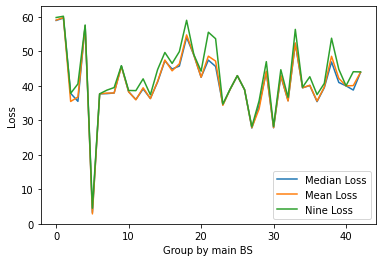

In [17]:
import matplotlib.pyplot as plt

x = [i for i in range(43)]

plt.plot(x, med, label="Median Loss")
plt.plot(x, mea, label="Mean Loss")
plt.plot(x, nin, label="Nine Loss")
plt.xlabel("Group by main BS")
plt.ylabel("Loss")

plt.legend()
plt.show()